# Check getting weights from model

In [1]:
from stack import Stack

In [2]:
model = Stack(input_dim=10, hidden_dim=100, output_dim=2)

In [3]:
model.affine1.weight.clone().shape

torch.Size([100, 10])

In [4]:
[w.shape for w in model.get_weights()]

[torch.Size([100, 10]),
 torch.Size([100]),
 torch.Size([2, 100]),
 torch.Size([2]),
 torch.Size([2, 10])]

# First reduction steps

In this part, we will take a simple model (one stack model) trained on the MNIST dataset and attempt to reduce it.

In [1]:
from stack import Stack, svdStack
from reduction import remove_outside_neurons, remove_weak_neurons, compute_bvv, get_cluster_weights
from reduction import cluster_neurons, svd_affine

import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
# download the MNIST dataset - if it's not already downloaded
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

def evaluate(model, testloader):
    # evaluate the model accuracy and loss on the test set
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in tqdm.tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images.view(-1, 784))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += F.cross_entropy(outputs, labels).item()
    model.to('cpu')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    # print('Average loss: %.3f' % (loss / total))
    print('Average loss: %.6f' % (loss / total))

# get a tensor of the first 100 images, shape: (100, 1, 28, 28)
images = torch.stack([image for image, label in [trainset[i] for i in range(100)]])
# reshape to (100, 784)
images = images.view(100, -1)
images.shape

torch.Size([100, 784])

In [4]:
# model = Stack(input_dim=784, hidden_dim=1024, output_dim=10, dropout=0)
# model = Stack(input_dim=784, hidden_dim=1024, output_dim=10, dropout=0.1)
model = Stack(input_dim=784, hidden_dim=1024, output_dim=10, dropout=0.1, activation=F.silu)  # SiLU activation -> trickier to reduce

# checkpoint = torch.load('./checkpoints/stack_epoch=9-step=4690.ckpt')['state_dict']
# checkpoint = torch.load('./checkpoints/stack_d_epoch=19-step=9380.ckpt')['state_dict']
checkpoint = torch.load('./checkpoints/stack_d_silu_epoch=19-step=9380.ckpt')['state_dict']
for k in list(checkpoint.keys()):
    # checkpoint[k.removeprefix('stack.')] = checkpoint.pop(k)
    checkpoint[k.removeprefix('model.')] = checkpoint.pop(k)

model.load_state_dict(checkpoint)
model.eval()

Stack(
  (affine1): Linear(in_features=784, out_features=1024, bias=True)
  (affine2): Linear(in_features=1024, out_features=10, bias=True)
  (affine_skip): Linear(in_features=784, out_features=10, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

## Remove outside neurons

First step is to remove the **outside neurons**.
These are the neurons which, whatever the input, will output either an always positive or an always negative value.
(Which means, once ReLU is applied, they will always output 0 or a positive value)

In order to do this, we run the model on all the images in the dataset, but this would be too computationally expensive!
Therefore, we will only run the model on a subset of the dataset: this is done in the **in-distribution images** part which follows.

The *Tries with random images* part is just an attempt to use completely random images instead of a subset of the dataset. 
This did not work well, so let's skip it.

### Tries with random images

In [28]:
random_imgs = torch.rand(1_000, 784)
images.shape, images.min(), images.max(), random_imgs.shape, random_imgs.min(), random_imgs.max()

(torch.Size([100, 784]),
 tensor(0.),
 tensor(1.),
 torch.Size([1000, 784]),
 tensor(7.1526e-07),
 tensor(1.0000))

In [29]:
new_weights = remove_outside_neurons(model.get_weights(), random_imgs)
new_model = Stack(input_dim=784, hidden_dim=new_weights[0].shape[0], output_dim=10)
new_model.set_weights(new_weights)

print(model(images).sum(), new_model(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model.parameters()])

tensor(-978.3373, grad_fn=<SumBackward0>) tensor(-817.3730, grad_fn=<SumBackward0>)


(821930, 306770)

Therefore, random images are not good enough to remove outside neurons...

In [33]:
torch.zeros(784).shape, torch.ones(784).shape
extreme_input = torch.stack([torch.zeros(784), torch.ones(784)])
extreme_input.shape

torch.Size([2, 784])

In [35]:
# let's make a tensor composed only of zeros and ones randomly of shape (100,784)
random_imgs = torch.randint(0, 2, (100, 784)).float()
random_imgs.shape

torch.Size([100, 784])

In [36]:
new_weights = remove_outside_neurons(model.get_weights(), random_imgs)
new_model = Stack(input_dim=784, hidden_dim=new_weights[0].shape[0], output_dim=10)
new_model.set_weights(new_weights)

print(model(images).sum(), new_model(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model.parameters()])

tensor(-978.3373, grad_fn=<SumBackward0>) tensor(-815.3214, grad_fn=<SumBackward0>)


(821930, 302000)

Just trying some various other inputs, but no success there. Looks like we need representatve examples.

### In-distribution images

In [7]:
new_weights = remove_outside_neurons(model.get_weights(), images)
new_model = Stack(input_dim=784, hidden_dim=new_weights[0].shape[0], output_dim=10)
new_model.set_weights(new_weights)
new_model.eval()

print(f"number of hidden neurons: {new_weights[0].shape[0]}")

print(model(images).sum(), new_model(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model.parameters()])

number of hidden neurons: 692
tensor(-4227.3525, grad_fn=<SumBackward0>) tensor(-5297.3730, grad_fn=<SumBackward0>)


(821930, 557990)

In [8]:
print('Original model:')
evaluate(model, testloader)
print('New model:')
evaluate(new_model, testloader)

Original model:


  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:04<00:00, 75.91it/s] 


Accuracy of the network on the 10000 test images: 97 %
Average loss: 0.002641
New model:


100%|██████████| 313/313 [00:03<00:00, 80.08it/s] 

Accuracy of the network on the 10000 test images: 96 %
Average loss: 0.003793


### Remove weak neurons

Once the **outside neurons** are removed, we can remove the **weak neurons**.

These are the neurons which, whatever the input, will output a small (weak) value.

In [71]:
# new_weights = [v[index][discard_neurons:], b[index][discard_neurons:], w[:, index][:, discard_neurons:], c, w_affine]
new_weights = remove_weak_neurons(new_model.get_weights(), discard_neurons=230)
new_model2 = Stack(input_dim=784, hidden_dim=new_weights[0].shape[0], output_dim=10)
new_model2.set_weights(new_weights)
new_model2.eval()

print(f"number of hidden neurons: {new_weights[0].shape[0]}")

print(model(images).sum(), new_model2(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model2.parameters()])

number of hidden neurons: 298
tensor(-3856.2852, grad_fn=<SumBackward0>) tensor(-3851.0703, grad_fn=<SumBackward0>)


(821930, 244760)

In [6]:
784*630 + 630 + 630*10 + 10 + 784*10

508700

In [72]:
print('New model2:')
evaluate(new_model2, testloader)

New model2:


100%|██████████| 313/313 [00:03<00:00, 81.35it/s] 

Accuracy of the network on the 10000 test images: 97 %
Average loss: 0.002490


### Cluster neurons

Finally, after removing the **outside neurons** and the **weak neurons**, we can **cluster** the remaining neurons.

In [73]:
v, b, w, c, w_affine = new_model2.get_weights()
v.shape, b.shape, w.shape, c.shape, w_affine.shape

(torch.Size([298, 784]),
 torch.Size([298]),
 torch.Size([10, 298]),
 torch.Size([10]),
 torch.Size([10, 784]))

In [75]:
import numpy as np

def get_cluster_weights(weights):
    """
    Compute the weighting for the clustering

    Args:
    weights: Tuple[torch.Tensor]
        The weights of the model, format: (v, b, w, c, w_affine)

    Returns:
    Tuple[torch.Tensor]
        The weights of the cluster, format: (v.shape[1])
    """
    v, _, w, _, _ = weights
    print(v.shape, w.shape)
    v = v.norm(dim=0)
    w = w.norm(dim=1)
    print(v.shape, w.shape)
    return v * w

def compute_distance_matrix_for_clustering_merge_signs(weights, ord=1, verbose=1):
    # """from usual weights, compute bv/|v|**2 which will be later clustered
    # they will then be concatenated with v/|v|"""
    weights = [w.T.detach() for w in weights]
    print([w.shape for w in weights])
    v, b, _, _, _ = weights
    norms = np.linalg.norm(v, axis=0, ord=ord)
    bvv = np.array([b[i] * v[:, i] / norms[i] ** 2 for i, _ in enumerate(v[0])])

    v_normed = v / norms
    # bvv = np.concatenate((bvv, v_normed.T), axis=1)

    cos_sim = lambda v, v_: 1 - np.abs(
        v @ v_.T / (np.linalg.norm(v) * np.linalg.norm(v_))
    )
    # cos_sim = lambda v, v_: 1 - v @ v_.T / (np.linalg.norm(v) * np.linalg.norm(v_))
    eucl_dist = lambda v, v_: np.linalg.norm(v - v_)

    D = np.zeros((norms.shape[0], norms.shape[0]))
    cluster_weights = get_cluster_weights(weights)
    # cluster_weights = compute_weights_for_clustering(weights, ord=ord, verbose=verbose)

    for i, m in enumerate(D):
        for j, _ in enumerate(m):
            if j > i:
                D[i, j] = eucl_dist(bvv[i, :], bvv[j, :]) + cos_sim(
                    v_normed[:, i], v_normed[:, j]
                )
                D[i, j] *= min(cluster_weights[i], cluster_weights[j])
            elif i > j:
                D[i, j] = D[j, i]
            else:
                D[i, j] = 0
    if verbose:
        print(f"Done computing M for clustering. Shape of bvv: {D.shape}")
    return D

compute_distance_matrix_for_clustering_merge_signs(new_model2.get_weights()).shape

[torch.Size([784, 298]), torch.Size([298]), torch.Size([298, 10]), torch.Size([10]), torch.Size([784, 10])]
torch.Size([784, 298]) torch.Size([298, 10])
torch.Size([298]) torch.Size([298])
Done computing M for clustering. Shape of bvv: (298, 298)


(298, 298)

In [10]:
def get_kink(tmp_weights):
    """
    Compute the kink of the cluster

    Args:
    tmp_weights: Tuple[torch.Tensor]
        The weights of the model, format: (v, b, w)

    Returns:
    xi: torch.Tensor
        The kink of the cluster
    """
    v, b, w = tmp_weights
    xi = b @ v.norm(dim=1)
    xi /= w.norm(dim=1) @ v.norm(dim=1)
    return xi


In [76]:
# new_weights2 = get_clustered_weights(new_model2.get_weights(), cluster)
# new_weights2 = [V, B, W.T, new_weights[3], new_weights[4]]
new_weights2 = cluster_neurons(new_model2.get_weights(), n_clusters=100, cluster_weights=None)
# new_weights2 = cluster_neurons(new_model2.get_weights(), n_clusters=100, cluster_weights=get_cluster_weights(new_model2.get_weights()).detach())
new_model3 = Stack(input_dim=784, hidden_dim=new_weights2[0].shape[0], output_dim=10)
new_model3.set_weights(new_weights2)

print(model(images).sum(), new_model3(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model3.parameters()])

Done clustering bvv. Shape of centers: (100, 1568)
tensor(-3856.2852, grad_fn=<SumBackward0>) tensor(-3645.6318, grad_fn=<SumBackward0>)


(821930, 87350)

In [ ]:
# calculate the number of parameters of the new model (100 clusters) and the original model (1024 neurons)
784 * 100 + 100 * 10 + 100 + 10 + 784 * 10, 784 * 1024 + 1024 + 1024 * 10 + 10

(87350, 814090)

In [77]:
print('New model3:')
evaluate(new_model3, testloader)

New model3:


100%|██████████| 313/313 [00:03<00:00, 80.77it/s] 

Accuracy of the network on the 10000 test images: 97 %
Average loss: 0.003030


### SVD affine weights

As a final touch, we can apply SVD to the affine weights of the model. 
This will hopefully allow us to reduce the number of parameters in the model even more.

In [78]:
# new_weights3 = [new_weights2[0], new_weights2[1], new_weights2[2], new_weights2[3], P, Q]
affine_neurons_left = 5
new_weights3 = svd_affine(new_model3.get_weights(), affine_neurons_left=affine_neurons_left)
new_model4 = svdStack(input_dim=784, hidden_dim=new_weights3[0].shape[0], output_dim=10, hidden_affine_dim=affine_neurons_left)
new_model4.set_weights(new_weights3)

print(model(images).sum(), new_model4(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model4.parameters()])

tensor(-3856.2852, grad_fn=<SumBackward0>) tensor(-3519.5176, grad_fn=<SumBackward0>)


(821930, 83480)

In [79]:
print('New model4:')
evaluate(new_model4, testloader)

New model4:


  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:03<00:00, 80.05it/s] 

Accuracy of the network on the 10000 test images: 96 %
Average loss: 0.003380


# Reducing a FFN (without residual/affine connection)

Similar as above, except we work with a regular feedforward network (FFN), so without residual affine connections.

In [1]:
from stack import Stack, svdStack, FFN
from reduction import remove_outside_neurons, remove_weak_neurons, compute_bvv, get_cluster_weights
from reduction import cluster_neurons, svd_affine

import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

def evaluate(model, testloader):
    # evaluate the model accuracy and loss on the test set
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in tqdm.tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images.view(-1, 784))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += F.cross_entropy(outputs, labels).item()
    model.to('cpu')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    # print('Average loss: %.3f' % (loss / total))
    print('Average loss: %.6f' % (loss / total))

# get a tensor of the first 100 images, shape: (100, 1, 28, 28)
images = torch.stack([image for image, label in [trainset[i] for i in range(100)]])
# reshape to (100, 784)
images = images.view(100, -1)
images.shape

torch.Size([100, 784])

In [3]:
# model = Stack(input_dim=784, hidden_dim=1024, output_dim=10, dropout=0.1)
model = FFN(input_dim=784, hidden_dim=1024, output_dim=10, dropout=0.1)

checkpoint = torch.load('./checkpoints/simpleFFN_epoch=19-step=9380.ckpt')['state_dict']
for k in list(checkpoint.keys()):
    checkpoint[k.removeprefix('model.')] = checkpoint.pop(k)

model.load_state_dict(checkpoint)
model.eval()

FFN(
  (affine1): Linear(in_features=784, out_features=1024, bias=True)
  (affine2): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Removing outside neurons should automatically return a model with an affine connection.

The next steps (removing weak neurons, clustering neurons, and applying SVD to affine weights) should then be the same as above.

In [9]:
new_weights = remove_outside_neurons(model.get_weights(), images)
new_model = Stack(input_dim=784, hidden_dim=new_weights[0].shape[0], output_dim=10)
new_model.set_weights(new_weights)
new_model.eval()

print(f"number of hidden neurons: {new_weights[0].shape[0]}")

print(model(images).sum(), new_model(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model.parameters()])

number of hidden neurons: 520
tensor(-3811.3840, grad_fn=<SumBackward0>) tensor(-3811.3840, grad_fn=<SumBackward0>)


(814090, 421250)

In [10]:
print('Original model:')
evaluate(model, testloader)
print('New model:')
evaluate(new_model, testloader)

Original model:


100%|██████████| 313/313 [00:04<00:00, 72.35it/s] 


Accuracy of the network on the 10000 test images: 97 %
Average loss: 0.002598
New model:


100%|██████████| 313/313 [00:04<00:00, 73.39it/s] 

Accuracy of the network on the 10000 test images: 97 %
Average loss: 0.002598


In [11]:
# new_weights = [v[index][discard_neurons:], b[index][discard_neurons:], w[:, index][:, discard_neurons:], c, w_affine]
new_weights = remove_weak_neurons(new_model.get_weights(), discard_neurons=230)
new_model2 = Stack(input_dim=784, hidden_dim=new_weights[0].shape[0], output_dim=10)
new_model2.set_weights(new_weights)
new_model2.eval()

print(f"number of hidden neurons: {new_weights[0].shape[0]}")

print(model(images).sum(), new_model2(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model2.parameters()])

number of hidden neurons: 290
tensor(-3811.3840, grad_fn=<SumBackward0>) tensor(-3770.6396, grad_fn=<SumBackward0>)


(814090, 238400)

In [12]:
print('New model2:')
evaluate(new_model2, testloader)

New model2:


100%|██████████| 313/313 [00:04<00:00, 73.13it/s] 

Accuracy of the network on the 10000 test images: 97 %
Average loss: 0.002605


In [13]:
# new_weights2 = get_clustered_weights(new_model2.get_weights(), cluster)
# new_weights2 = [V, B, W.T, new_weights[3], new_weights[4]]
new_weights2 = cluster_neurons(new_model2.get_weights(), n_clusters=100, cluster_weights=None)
# new_weights2 = cluster_neurons(new_model2.get_weights(), n_clusters=100, cluster_weights=get_cluster_weights(new_model2.get_weights()).detach())
new_model3 = Stack(input_dim=784, hidden_dim=new_weights2[0].shape[0], output_dim=10)
new_model3.set_weights(new_weights2)

print(model(images).sum(), new_model3(images).sum())

# number of parameters of each model
sum([w.numel() for w in model.parameters()]), sum([w.numel() for w in new_model3.parameters()])

Done clustering bvv. Shape of centers: (100, 1568)
tensor(-3811.3840, grad_fn=<SumBackward0>) tensor(-3536.1545, grad_fn=<SumBackward0>)


(814090, 87350)

In [14]:
print('New model3:')
evaluate(new_model3, testloader)

New model3:


100%|██████████| 313/313 [00:04<00:00, 71.48it/s] 

Accuracy of the network on the 10000 test images: 97 %
Average loss: 0.003189


# Transformer debugging

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
embed_layer = nn.Embedding(1024, 64)
batch_size = 4
sentence_length = 100
random_input = torch.randint(0, 1024, (batch_size, sentence_length))
random_input.shape, embed_layer(random_input).shape, embed_layer(random_input).dtype

(torch.Size([4, 100]), torch.Size([4, 100, 64]), torch.float32)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
positional_encoding = PositionalEncoding(64, 0)
positional_encoding(random_input).shape

RuntimeError: The size of tensor a (100) must match the size of tensor b (64) at non-singleton dimension 2

# Vision Transformer on Tiny ImageNet

In [2]:
from matplotlib import pyplot as plt

from torchvision import transforms
from datasets import load_dataset
from simple_ViT import VisionTransformer
from dataset_tiny_imagenet import TinyImageNetDataModule

from lightning import Trainer
import torch
from torch import nn, optim
import lightning as L

In [ ]:
tiny_imagenet = load_dataset('Maysee/tiny-imagenet', split='valid')
tiny_imagenet

Found cached dataset parquet (C:/Users/alexi/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-2eb6c3acd8ebc62a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

In [3]:
image0 = transforms.ToTensor()(tiny_imagenet[0]["image"])

In [4]:
image0.shape

torch.Size([3, 64, 64])

In [5]:
tiny_imagenet[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x29AD7116B90>,
 'label': 0}

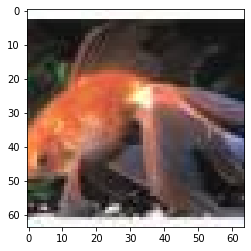

In [6]:
plt.imshow(image0.permute(1, 2, 0))
plt.show()

In [7]:
vit = VisionTransformer(img_size=64, patch_size=4, in_channels=3, num_classes=10, embed_dim=32, num_heads=8, mlp_dim=128, num_layers=2)
vit(image0.unsqueeze(0)), vit(image0.unsqueeze(0)).shape

(tensor([[ 0.1440,  0.3413, -0.3299, -0.1898, -0.5004,  0.9176, -0.6309, -0.8269,
          -0.4450, -1.0778]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 10]))

In [3]:
# dataset = TinyImageNetDataset(tiny_imagenet, transform=transforms.ToTensor())
dataloader = TinyImageNetDataModule(batch_size=32, num_workers=4)

In [4]:
dataloader.setup()
train_dataloader = dataloader.train_dataloader()

Found cached dataset parquet (C:/Users/alexi/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-2eb6c3acd8ebc62a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (C:/Users/alexi/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-2eb6c3acd8ebc62a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [5]:
# let's inspect the dataloader
# dataloader.setup()
# train_dataloader = dataloader.train_dataloader()
for i, batch in enumerate(train_dataloader):
# for i, batch in enumerate(dataloader.train_dataloader()):
    tmp = batch
    print(batch[0].shape, batch[1].shape)
    if i == 0:
        break

torch.Size([32, 3, 64, 64]) torch.Size([32])


In [6]:
tmp[1]

tensor([ 72, 108,  21, 110,  24, 107,  23,   8, 185,  25,  53,  95,  39,  88,
        129,  51,   1, 167, 115, 149, 153, 147, 153, 178,  72,  59,  61, 127,
         13, 140, 102, 159])

In [7]:
for i, e in enumerate(tmp[1].tolist()):
    if e == 153: print(i)

20
22


tensor(153)


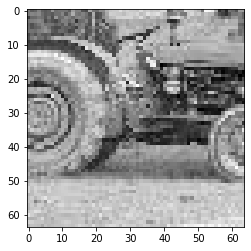

tensor(153)


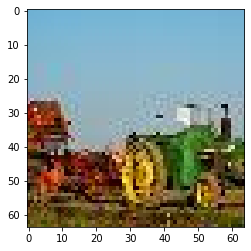

In [8]:
i = 20
print(tmp[1][i])
plt.imshow(tmp[0][i].permute(1,2,0))
plt.show()
i = 22
print(tmp[1][i])
plt.imshow(tmp[0][i].permute(1,2,0))
plt.show()

In [11]:
dataloader

In [ ]:
torch.set_float32_matmul_precision('medium')

class SimpleViT(L.LightningModule):
    def __init__(self):
        super(SimpleViT, self).__init__()
        self.model = VisionTransformer(img_size=64, patch_size=4, in_channels=3, num_classes=200, embed_dim=32, num_heads=8, mlp_dim=128, num_layers=2)

    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, mode='train'):
        x, y = batch
        y_hat = self(x)
        # loss = F.cross_entropy(y_hat, y)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log(f'{mode}_loss', loss, prog_bar=True)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log(f'{mode}_acc', acc, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

dm = TinyImageNetDataModule(batch_size=32, num_workers=4)
model = SimpleViT()

trainer = Trainer(
    max_epochs=1,
)
trainer.fit(model, datamodule=dm)

In [ ]:
# del(tensorflow)
import tensorflow
tensorflow.io